## Tytuł projektu

Dane pobrałem stąd - https://www.kaggle.com/orgesleka/used-cars-database . Są to ogłoszenia o sprzedaży samochodów z niemieckiego serwisu Ebay, zebrane w roku 2016. Na ich podstawie postaram się wyestymować cenę samochodu w zależności od jego parametrów, takich jak moc oraz lic


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
autos = pd.read_csv('autos.csv', encoding='cp1252')

In [3]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Jak widać, mamy sporo kolumn, z czego nie wszystkie nas interesują, część ma też puste wartości.
Zajmijmy się wstępną obróbką danych. Najpierw zdecydujemy, jakie kolumny mogą zawierać wartościowe informacje. Kolumna name nie jest interesująca - jest to po prostu tytuł ogłoszenia. Wszystkie potrzebne informacje o autach są zawarte w innych kolumnach. Kolumna seller zawiera informacje o tym, czy sprzedawcą jest osoba prywatna, czy dealer, też jest nieistotna. Usuniemy też kolumny z datą stworzenia ogłoszenia, liczbą zdjęć, kodem pocztowym, ostatnim momentem, kiedy ogłoszenie było widoczne, miesiącem rejestracji (zostawimy rok).

In [4]:
autos = autos.drop(columns = ['dateCrawled', 'name', 'seller', 'monthOfRegistration', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen'])

Kolumna offerType zawiera tylko dwie wartości, z czego druga występuje bardzo rzadko. Nie wniesie żadnych informacji, więc ją usuniemy.

In [5]:
autos['offerType'].value_counts()
autos = autos.drop(columns = ['offerType'])

Załóżmy, że powypadkowe samochody nas nie iteresują. W takim razie, usuńmy wszystkie auta, które mają jakieś nienaprawione uszkodzenia.

In [6]:
autos = autos[autos['notRepairedDamage'] != 'ja']

Odfiltrujmy wartości, które na pewno nie są poprawne, np. samochody zarejestrowane w 1200 roku.

In [7]:
autos = autos[autos['yearOfRegistration'].between(1950, 2016)]
autos = autos[autos['price'].between(200, 75000)]
autos = autos[autos['powerPS'].between(30, 800)]
autos = autos[autos['kilometer'].between(1000, 400000)]

Teraz zobaczmy, czy mamy jakieś brakujące dane.

In [8]:
autos.isnull().sum()

price                     0
abtest                    0
vehicleType            9084
yearOfRegistration        0
gearbox                4622
powerPS                   0
model                  9744
kilometer                 0
fuelType              12894
brand                     0
notRepairedDamage     41985
dtype: int64

Jak widać, 5 kolumn ma brakujące dane. Możemy albo usunąć te wiersze, albo uzupełnić je innymi danymi. Ewentualnie usunąć całą kolumnę, co zrobię z kolumną notRepairedDamage ( już i tak uzyskaliśmy potrzebne z niej informacje). 

In [9]:
autos = autos.drop(columns = ['notRepairedDamage'])

W przypadku skrzyni biegów, możemy uzupełnić wartości skojarzone z marką auta ( to pole nie zawiera żadnych pustych wartości). To samo zrobimy z typem paliwa.

In [10]:
def fill_values (column_in, column_out, fill_null):
    val_dict = { 'brand_name' : ('gear_type', 1)}

    for (brand_name, gear_type), gear_count in autos.groupby(column_in)[column_out].value_counts().items():
        if brand_name in val_dict :
            if gear_count > val_dict[brand_name][1] :
                val_dict[brand_name] = (gear_type, gear_count)
        else:
            val_dict[brand_name] = (gear_type, gear_count)

    for brand_name in val_dict:
        if fill_null:
            autos.loc[(autos[column_in] == brand_name) & (autos[column_out].isnull()), column_out] = val_dict[brand_name][0] 
        else:
            autos.loc[(autos[column_in] == brand_name) & (autos[column_out] == 0), column_out] = val_dict[brand_name][0] 

fill_values('brand', 'gearbox', True)

fill_values('brand', 'fuelType', True)

Następnie usuniemy wszystkie modele, które nie istnieją, a potem uzupełnimy wartości kolumny vehicleType skojarzone z nazwą modelu.

In [11]:
autos = autos[autos['model'].notnull()]

In [12]:
fill_values('model', 'vehicleType', True)

Jak widać, nasze dane nie zawierają żadnych pustych pól. Warto też zobaczyć, w jakim stanie aktualnie jest nasz data frame.

In [13]:
print(autos.isnull().sum())
autos.head()

price                 0
abtest                0
vehicleType           0
yearOfRegistration    0
gearbox               0
powerPS               0
model                 0
kilometer             0
fuelType              0
brand                 0
dtype: int64


,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand
2,9800,test,suv,2004,automatik,163,grand,125000,diesel,jeep
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot
8,14500,control,bus,2014,manuell,125,c_max,30000,benzin,ford


Nie przejmujemy się też tym, czy oferta była wystawion jako abtest. Dodatkowo, uzupełnijmy też wartości kolumny powerPS w miejscach, gdzie jest równa 0 - cena będzie zależna od mocy.

In [14]:
autos = autos.drop(columns = ['abtest'])

In [15]:
fill_values('model', 'powerPS', False)

In [16]:
autos.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand
2,9800,suv,2004,automatik,163,grand,125000,diesel,jeep
3,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen
4,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda
6,2200,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot
8,14500,bus,2014,manuell,125,c_max,30000,benzin,ford


Ostatnią rzeczą jaką wykonamy, jest zamienieni wszystkich kolumn z liczbami na typ numeryczny ( ponieważ niektóre są typu object) oraz zamiana kolumn z dwoma wartościami na 0 oraz 1 (czyli gearbox).

In [17]:
autos['powerPS'] = pd.to_numeric(autos['powerPS'])
autos.loc[autos['gearbox'] == 'manuell', 'gearbox'] = 0
autos.loc[autos['gearbox'] == 'automatik', 'gearbox'] = 1
autos['gearbox'] = pd.to_numeric(autos['gearbox'])

Teraz możemy sobie zwizualizować różne zależności. Zobaczmy najpierw, czy są jakieś koleracje między danymi.

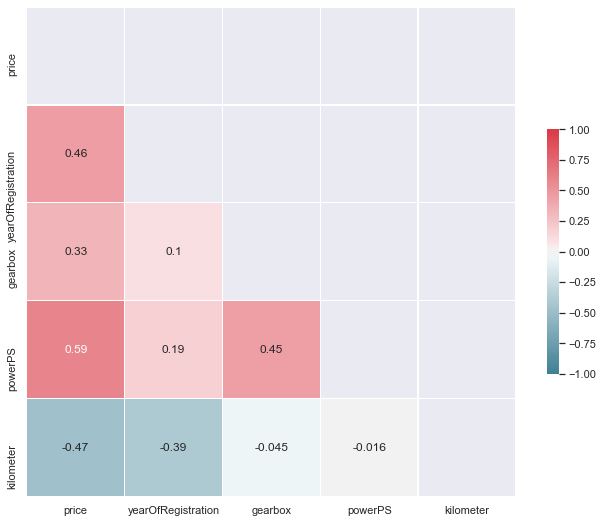

,price,yearOfRegistration,gearbox,powerPS,kilometer
price,1.000000,0.457560,0.329966,0.594244,-0.466404
yearOfRegistration,0.457560,1.000000,0.102811,0.186749,-0.392466
gearbox,0.329966,0.102811,1.000000,0.453097,-0.045247
powerPS,0.594244,0.186749,0.453097,1.000000,-0.015508
kilometer,-0.466404,-0.392466,-0.045247,-0.015508,1.000000


In [18]:
sns.set(style="darkgrid")

corr = autos.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)
plt.show()
corr

Jak widać, jakieś są, szczególnie, po oczyszczeniu danych ( przed były bliskie zeru). Największa koleracja (pozytywna) występuje pomiędzy ceną, a mocą auta, a największa (negatywna) między ceną, a przebiegiem.

In [19]:
autos.describe()

,price,yearOfRegistration,gearbox,powerPS,kilometer
count,270425.000000,270425.000000,270425.000000,270425.000000,270425.000000
mean,6605.044419,2003.570931,0.230696,127.871121,124360.894888
std,7609.682312,6.516198,0.421279,61.161495,39620.099580
min,200.000000,1950.000000,0.000000,30.000000,5000.000000
25%,1690.000000,2000.000000,0.000000,82.000000,100000.000000
50%,3950.000000,2004.000000,0.000000,116.000000,150000.000000
75%,8699.000000,2008.000000,0.000000,151.000000,150000.000000
max,75000.000000,2016.000000,1.000000,776.000000,150000.000000


Teraz, podzielimy dane na zestaw treningowy i testowy.

In [20]:
autos_train, autos_test = train_test_split(autos, test_size=0.2)

In [21]:
autos_train = pd.get_dummies(autos_train, drop_first=True)
print(autos_train.columns)

Index(['price', 'yearOfRegistration', 'gearbox', 'powerPS', 'kilometer',
       'vehicleType_bus', 'vehicleType_cabrio', 'vehicleType_coupe',
       'vehicleType_kleinwagen', 'vehicleType_kombi',
       ...
       'brand_saab', 'brand_seat', 'brand_skoda', 'brand_smart',
       'brand_subaru', 'brand_suzuki', 'brand_toyota', 'brand_trabant',
       'brand_volkswagen', 'brand_volvo'],
      dtype='object', length=305)
